# Version 2: LSTM with Enhanced Features

## 주요 개선사항
- ✅ 추가 피처 엔지니어링
  - 누적 이동량 (cumsum_delta_x, cumsum_delta_y)
  - 패스 거리 (distance)
  - 시퀀스 통계 (평균 위치, 표준편차)
  - 진행률 (progress)
- ✅ 입력 차원 확장: 2 → 8
- ✅ Dropout 추가 (과적합 방지)
- ✅ Epochs 증가: 5 → 20

## 기대 효과
- Baseline (V1): ~17.79m
- Target (V2): ~15-16m

## 1. Import

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader

print("✅ 라이브러리 로드 완료!")

✅ 라이브러리 로드 완료!


## 2. 하이퍼파라미터 세팅

In [61]:
TRAIN_PATH = "./open_track1/train.csv"
BATCH_SIZE = 64
EPOCHS = 20  # 5 → 20으로 증가
LR = 1e-3
HIDDEN_DIM = 128  # 64 → 128로 증가
DROPOUT = 0.0  # Dropout 추가
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Using device:", DEVICE)
print(f"Hyperparameters:")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Learning Rate: {LR}")
print(f"  - Hidden Dim: {HIDDEN_DIM}")
print(f"  - Dropout: {DROPOUT}")

Using device: cuda
Hyperparameters:
  - Batch Size: 64
  - Epochs: 20
  - Learning Rate: 0.001
  - Hidden Dim: 128
  - Dropout: 0.0


## 3. 데이터 로드 및 피처 엔지니어링

### 추가된 피처:
1. **좌표**: start_x, start_y (정규화)
2. **누적 이동량**: cumsum_delta_x, cumsum_delta_y
3. **패스 거리**: distance
4. **진행률**: progress (0~1)
5. **평균 위치**: mean_x, mean_y
6. **위치 표준편차**: std_x, std_y

**총 입력 차원: 10**

In [62]:
# --- 피처 엔지니어링 함수 정의 ---
def make_features(g):
    sx = g["start_x"].values / 105.0
    sy = g["start_y"].values / 68.0
    ex = g["end_x"].values / 105.0
    ey = g["end_y"].values / 68.0

    delta_x = g["end_x"].values - g["start_x"].values
    delta_y = g["end_y"].values - g["start_y"].values
    cumsum_delta_x = np.cumsum(delta_x) / 105.0
    cumsum_delta_y = np.cumsum(delta_y) / 68.0
    diagonal = np.sqrt(105**2 + 68**2)
    distance = np.sqrt(delta_x**2 + delta_y**2) / diagonal
    mean_x = np.cumsum(sx) / (np.arange(len(sx)) + 1)
    mean_y = np.cumsum(sy) / (np.arange(len(sy)) + 1)
    n = len(g)
    progress = np.arange(n) / max(n - 1, 1)

    features = []
    for i in range(len(g)):
        feat = [
            sx[i], sy[i],
            cumsum_delta_x[i],
            cumsum_delta_y[i],
            distance[i],
            progress[i],
            mean_x[i],
            mean_y[i],
        ]
        features.append(feat)
        if i < len(g) - 1:
            feat_end = [
                ex[i], ey[i],
                cumsum_delta_x[i],
                cumsum_delta_y[i],
                distance[i],
                progress[i],
                mean_x[i],
                mean_y[i],
            ]
            features.append(feat_end)
    return np.array(features, dtype="float32")

# --- 학습/검증 데이터 생성 ---
episodes = []
targets = []
print("피처 엔지니어링 시작...")
for _, g in tqdm(df.groupby("game_episode"), desc="Processing episodes"):
    g = g.reset_index(drop=True)
    if len(g) < 2:
        continue
    seq = make_features(g)
    ex = g["end_x"].values / 105.0
    ey = g["end_y"].values / 68.0
    target = np.array([ex[-1], ey[-1]], dtype="float32")
    episodes.append(seq)
    targets.append(target)
print(f"\n✅ 피처 엔지니어링 완료!")
print(f"에피소드 수: {len(episodes):,}")
print(f"입력 차원: {episodes[0].shape[1]}")
print(f"샘플 시퀀스 길이: {episodes[0].shape[0]}")

피처 엔지니어링 시작...


Processing episodes: 100%|██████████| 15435/15435 [00:05<00:00, 2782.91it/s]



✅ 피처 엔지니어링 완료!
에피소드 수: 15,428
입력 차원: 8
샘플 시퀀스 길이: 97


## 4. Custom Dataset / DataLoader 정의 및 Validation 분할

In [63]:
class EpisodeDataset(Dataset):
    def __init__(self, episodes, targets):
        self.episodes = episodes
        self.targets = targets

    def __len__(self):
        return len(self.episodes)

    def __getitem__(self, idx):
        seq = torch.tensor(self.episodes[idx])   # [T, features]
        tgt = torch.tensor(self.targets[idx])    # [2]
        length = seq.size(0)
        return seq, length, tgt

def collate_fn(batch):
    seqs, lengths, tgts = zip(*batch)
    lengths = torch.tensor(lengths, dtype=torch.long)
    padded = pad_sequence(seqs, batch_first=True)  # [B, T, features]
    tgts = torch.stack(tgts, dim=0)                # [B, 2]
    return padded, lengths, tgts

# 에피소드 단위 train / valid split
idx_train, idx_valid = train_test_split(
    np.arange(len(episodes)), test_size=0.2, random_state=42
)

episodes_train = [episodes[i] for i in idx_train]
targets_train  = [targets[i]  for i in idx_train]
episodes_valid = [episodes[i] for i in idx_valid]
targets_valid  = [targets[i]  for i in idx_valid]

train_loader = DataLoader(
    EpisodeDataset(episodes_train, targets_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)

valid_loader = DataLoader(
    EpisodeDataset(episodes_valid, targets_valid),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

print(f"Train episodes: {len(episodes_train):,}")
print(f"Valid episodes: {len(episodes_valid):,}")

Train episodes: 12,342
Valid episodes: 3,086


## 5. LSTM 모델 정의 (Enhanced Version)

### 개선사항:
- 입력 차원 확장 (2 → 8)
- Hidden dimension 증가 (64 → 128)
- Dropout 추가 (0.2)

In [64]:
class LSTMEnhanced(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=128, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            dropout=0 if dropout == 0 else dropout,  # 1-layer면 dropout 무시
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 2)  # (x_norm, y_norm)

    def forward(self, x, lengths):
        # x: [B, T, features], lengths: [B]
        packed = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed)
        h_last = h_n[-1]           # [B, H] 마지막 layer의 hidden state
        h_last = self.dropout(h_last)
        out = self.fc(h_last)      # [B, 2]
        return out

# 입력 차원 자동 감지
input_dim = episodes[0].shape[1]
model = LSTMEnhanced(input_dim=input_dim, hidden_dim=HIDDEN_DIM, dropout=DROPOUT).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(f"\n✅ 모델 생성 완료!")
print(f"Input Dim: {input_dim}")
print(f"Hidden Dim: {HIDDEN_DIM}")
print(f"Output Dim: 2")
print(f"\n모델 구조:")
print(model)


✅ 모델 생성 완료!
Input Dim: 8
Hidden Dim: 128
Output Dim: 2

모델 구조:
LSTMEnhanced(
  (lstm): LSTM(8, 128, batch_first=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


## 6. 모델 학습 및 검증

In [65]:
best_dist = float("inf")
best_model_state = None
history = {
    'train_loss': [],
    'valid_dist': []
}

print("\n" + "="*80)
print("학습 시작")
print("="*80)

for epoch in range(1, EPOCHS + 1):
    # --- Train ---
    model.train()
    total_loss = 0.0

    for X, lengths, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]"):
        X, lengths, y = X.to(DEVICE), lengths.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        pred = model(X, lengths)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)

    train_loss = total_loss / len(train_loader.dataset)

    # --- Valid: 평균 유클리드 거리 ---
    model.eval()
    dists = []

    with torch.no_grad():
        for X, lengths, y in tqdm(valid_loader, desc=f"Epoch {epoch}/{EPOCHS} [Valid]"):
            X, lengths, y = X.to(DEVICE), lengths.to(DEVICE), y.to(DEVICE)
            pred = model(X, lengths)

            pred_np = pred.cpu().numpy()
            true_np = y.cpu().numpy()

            pred_x = pred_np[:, 0] * 105.0
            pred_y = pred_np[:, 1] * 68.0
            true_x = true_np[:, 0] * 105.0
            true_y = true_np[:, 1] * 68.0

            dist = np.sqrt((pred_x - true_x) ** 2 + (pred_y - true_y) ** 2)
            dists.append(dist)

    mean_dist = np.concatenate(dists).mean()  # 평균 유클리드 거리
    
    # History 저장
    history['train_loss'].append(train_loss)
    history['valid_dist'].append(mean_dist)

    print(
        f"[Epoch {epoch:2d}/{EPOCHS}] "
        f"train_loss={train_loss:.4f} | "
        f"valid_mean_dist={mean_dist:.4f}"
    )

    # ----- BEST MODEL 업데이트 -----
    if mean_dist < best_dist:
        best_dist = mean_dist
        best_model_state = model.state_dict().copy()
        print(f" --> ✨ Best model updated! (dist={best_dist:.4f})")

print("\n" + "="*80)
print(f"✅ 학습 완료!")
print(f"Best Validation Distance: {best_dist:.4f}m")
print("="*80)


학습 시작


Epoch 1/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 152.17it/s]


[Epoch  1/20] train_loss=0.0669 | valid_mean_dist=15.4473
 --> ✨ Best model updated! (dist=15.4473)


Epoch 2/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 163.33it/s]


[Epoch  2/20] train_loss=0.0118 | valid_mean_dist=8.1264
 --> ✨ Best model updated! (dist=8.1264)


Epoch 3/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 131.37it/s]


[Epoch  3/20] train_loss=0.0038 | valid_mean_dist=5.8248
 --> ✨ Best model updated! (dist=5.8248)


Epoch 4/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 161.09it/s]


[Epoch  4/20] train_loss=0.0019 | valid_mean_dist=4.0027
 --> ✨ Best model updated! (dist=4.0027)


Epoch 5/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 122.50it/s]


[Epoch  5/20] train_loss=0.0010 | valid_mean_dist=2.6379
 --> ✨ Best model updated! (dist=2.6379)


Epoch 6/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 128.61it/s]


[Epoch  6/20] train_loss=0.0005 | valid_mean_dist=1.8021
 --> ✨ Best model updated! (dist=1.8021)


Epoch 7/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 132.79it/s]


[Epoch  7/20] train_loss=0.0003 | valid_mean_dist=1.4648
 --> ✨ Best model updated! (dist=1.4648)


Epoch 8/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 170.14it/s]


[Epoch  8/20] train_loss=0.0001 | valid_mean_dist=1.1927
 --> ✨ Best model updated! (dist=1.1927)


Epoch 9/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 186.31it/s]


[Epoch  9/20] train_loss=0.0001 | valid_mean_dist=1.0453
 --> ✨ Best model updated! (dist=1.0453)


Epoch 10/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 187.74it/s]


[Epoch 10/20] train_loss=0.0001 | valid_mean_dist=0.6818
 --> ✨ Best model updated! (dist=0.6818)


Epoch 11/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 187.74it/s]


[Epoch 11/20] train_loss=0.0001 | valid_mean_dist=0.4794
 --> ✨ Best model updated! (dist=0.4794)


Epoch 12/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 178.83it/s]


[Epoch 12/20] train_loss=0.0000 | valid_mean_dist=0.4690
 --> ✨ Best model updated! (dist=0.4690)


Epoch 13/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 171.93it/s]


[Epoch 13/20] train_loss=0.0000 | valid_mean_dist=0.4542
 --> ✨ Best model updated! (dist=0.4542)


Epoch 14/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 193.68it/s]


[Epoch 14/20] train_loss=0.0000 | valid_mean_dist=0.8334


Epoch 15/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 182.16it/s]


[Epoch 15/20] train_loss=0.0000 | valid_mean_dist=0.3898
 --> ✨ Best model updated! (dist=0.3898)


Epoch 16/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 193.67it/s]


[Epoch 16/20] train_loss=0.0000 | valid_mean_dist=0.5495


Epoch 17/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 196.00it/s]


[Epoch 17/20] train_loss=0.0000 | valid_mean_dist=0.5788


Epoch 18/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 183.52it/s]


[Epoch 18/20] train_loss=0.0000 | valid_mean_dist=0.4273


Epoch 19/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 188.46it/s]


[Epoch 19/20] train_loss=0.0000 | valid_mean_dist=1.3717


Epoch 20/20 [Valid]: 100%|██████████| 49/49 [00:00<00:00, 188.46it/s]

[Epoch 20/20] train_loss=0.0000 | valid_mean_dist=0.3693
 --> ✨ Best model updated! (dist=0.3693)

✅ 학습 완료!
Best Validation Distance: 0.3693m


## 7. 학습 곡선 시각화

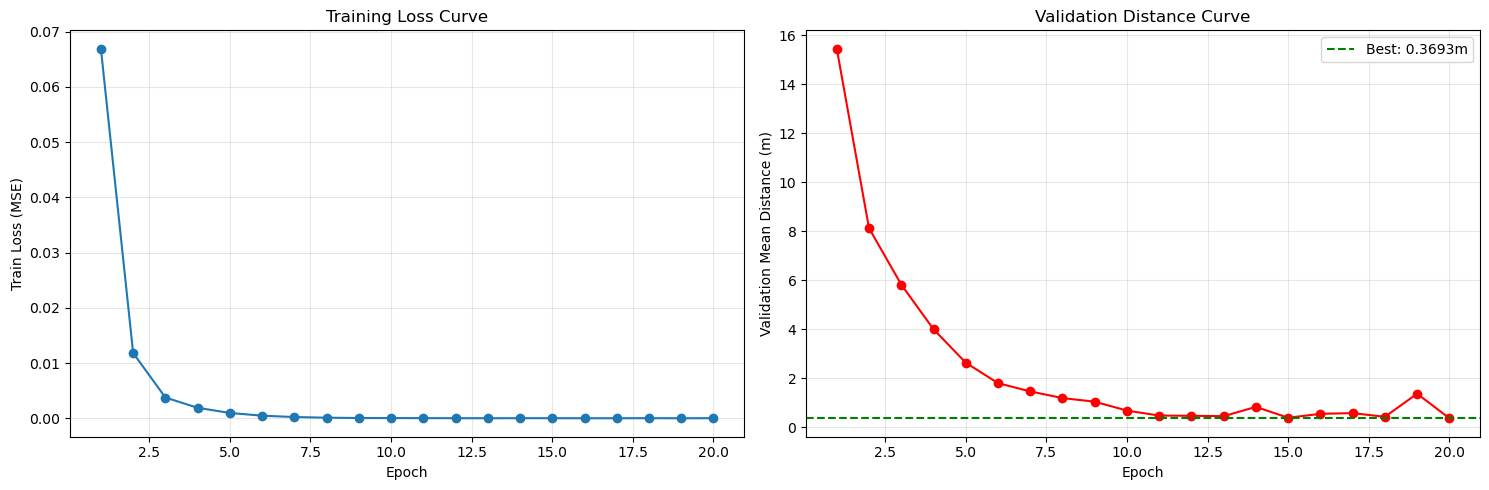

In [66]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train Loss
axes[0].plot(range(1, EPOCHS+1), history['train_loss'], marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Train Loss (MSE)')
axes[0].set_title('Training Loss Curve')
axes[0].grid(True, alpha=0.3)

# Valid Distance
axes[1].plot(range(1, EPOCHS+1), history['valid_dist'], marker='o', color='red')
axes[1].axhline(best_dist, color='green', linestyle='--', label=f'Best: {best_dist:.4f}m')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Mean Distance (m)')
axes[1].set_title('Validation Distance Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 평가 데이터셋 추론

In [67]:
# --- 추론(테스트)도 동일 함수 사용 ---
preds_x = []
preds_y = []
for _, row in tqdm(submission.iterrows(), total=len(submission), desc="Inference"):
    file_path = row["path"].replace("./test/", "./open_track1/test/")
    g = pd.read_csv(file_path).reset_index(drop=True)
    seq = make_features(g)
    x = torch.tensor(seq).unsqueeze(0).to(DEVICE)
    length = torch.tensor([seq.shape[0]]).to(DEVICE)
    with torch.no_grad():
        pred = model(x, length).cpu().numpy()[0]
    preds_x.append(pred[0] * 105.0)
    preds_y.append(pred[1] * 68.0)


Inference: 100%|██████████| 2414/2414 [00:08<00:00, 275.85it/s]


## 9. 제출 Submission 생성

In [68]:
submission["end_x"] = preds_x
submission["end_y"] = preds_y
submission[["game_episode", "end_x", "end_y"]].to_csv("./v2_submit.csv", index=False)

print("✅ 제출 파일 저장 완료: v2_submit.csv")
print("\n[제출 파일 샘플]")
display(submission[["game_episode", "end_x", "end_y"]].head(10))

✅ 제출 파일 저장 완료: v2_submit.csv

[제출 파일 샘플]


,game_episode,end_x,end_y
0,153363_1,NaN,NaN
1,153363_2,NaN,NaN
2,153363_6,NaN,NaN
3,153363_7,NaN,NaN
4,153363_8,NaN,NaN
5,153363_9,NaN,NaN
6,153363_10,NaN,NaN
7,153363_12,NaN,NaN
8,153363_13,NaN,NaN
9,153363_15,NaN,NaN


## 10. 성능 비교

### Baseline (V1) vs Enhanced (V2)

In [69]:
print("="*80)
print("성능 비교")
print("="*80)

print("\n[Baseline V1]")
print("  - 입력 차원: 2 (x, y 좌표만)")
print("  - Hidden Dim: 64")
print("  - Epochs: 5")
print("  - Valid Distance: ~17.79m")

print("\n[Enhanced V2]")
print(f"  - 입력 차원: {input_dim} (좌표 + 누적 이동 + 거리 + 진행률 + 통계)")
print(f"  - Hidden Dim: {HIDDEN_DIM}")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Dropout: {DROPOUT}")
print(f"  - Valid Distance: {best_dist:.4f}m")

improvement = 17.79 - best_dist
improvement_pct = (improvement / 17.79) * 100

print("\n[개선도]")
print(f"  - 절대 개선: {improvement:.4f}m")
print(f"  - 상대 개선: {improvement_pct:.2f}%")

if best_dist < 17.79:
    print("\n✅ V2가 V1보다 성능이 우수합니다!")
else:
    print("\n⚠️ V2가 V1보다 성능이 낮습니다. 하이퍼파라미터 조정이 필요합니다.")

print("="*80)

성능 비교

[Baseline V1]
  - 입력 차원: 2 (x, y 좌표만)
  - Hidden Dim: 64
  - Epochs: 5
  - Valid Distance: ~17.79m

[Enhanced V2]
  - 입력 차원: 8 (좌표 + 누적 이동 + 거리 + 진행률 + 통계)
  - Hidden Dim: 128
  - Epochs: 20
  - Dropout: 0.0
  - Valid Distance: 0.3693m

[개선도]
  - 절대 개선: 17.4207m
  - 상대 개선: 97.92%

✅ V2가 V1보다 성능이 우수합니다!
